In [1]:
# this is just to widen up the jupyter cells to 90% of the window size
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# VAE on ECG500 Data
#### Inspiration
This notebook is heavily inspired by the following article:

Pereira, J., & Silveira, M. (2019). Learning Representations from Healthcare Time Series Data for Unsupervised Anomaly Detection. 2019 IEEE International Conference on Big Data and Smart Computing (BigComp), 1–7. https://doi.org/10.1109/BIGCOMP.2019.8679157

Furthermore the implementation of the variational auto-encoder is based on:

https://github.com/bnsreenu/python_for_microscopists/blob/master/178_179_variational_autoencoders_mnist.py

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from keras import regularizers
from keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from keras.layers import Lambda, Dense, Flatten, Dropout, Input, LSTM, RepeatVector, TimeDistributed, Conv1D, Conv1DTranspose, Masking, Bidirectional, Reshape
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras import regularizers

import tensorflow.compat.v1.keras.backend as K

tf.compat.v1.disable_eager_execution()

from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import seaborn as sn

In [3]:
data = pd.read_csv("ECG5000_TRAIN.txt", header=None)
data.rename(columns = {0 : 'label'}, inplace=True)
data.head()

,label,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1,-0.11252,-2.82720,-3.7739,-4.3498,-4.3760,-3.4750,-2.1814,-1.81830,-1.25050,...,0.16035,0.79217,0.93354,0.79696,0.578620,0.25774,0.22808,0.12343,0.92529,0.19314
1,1,-1.10090,-3.99680,-4.2858,-4.5066,-4.0224,-3.2344,-1.5661,-0.99226,-0.75468,...,0.56033,0.53836,0.65688,0.78749,0.724050,0.55578,0.47633,0.77382,1.11960,-1.43620
2,1,-0.56709,-2.59350,-3.8742,-4.5841,-4.1874,-3.1515,-1.7429,-1.49070,-1.18360,...,1.28480,0.88607,0.53145,0.31138,-0.021919,-0.71368,-0.53220,0.32110,0.90423,-0.42180
3,1,0.49047,-1.91440,-3.6164,-4.3188,-4.2680,-3.8811,-2.9933,-1.67110,-1.33390,...,0.49117,0.35082,0.49911,0.60034,0.842070,0.95207,0.99013,1.08680,1.40300,-0.38356
4,1,0.80023,-0.87425,-2.3848,-3.9733,-4.3382,-3.8024,-2.5345,-1.78340,-1.59450,...,0.96661,1.14890,0.95843,1.05900,1.371700,1.27740,0.96030,0.97102,1.61440,1.42150


In [4]:
print("Shape of data:\t\t", data.shape)
print("Count per label:\t", Counter(data['label']))

Shape of data:		 (5000, 141)
Count per label:	 Counter({1: 2919, 2: 1767, 4: 194, 3: 96, 5: 24})


In [5]:
def stylePlot(title):
    plt.title(title)
    plt.ylim(-6, 3.5)
    plt.xlabel('Time')
    plt.ylabel('ECG signal')
    

def plotSamplesOfOneLabel(df, label):
    
    rows_with_label = df[df['label'] == label]
    
    np_array_form = np.array(rows_with_label)
    
    mean_of_plots = np.mean(np_array_form, axis=0)
    std_of_plots = np.std(np_array_form, axis=0)
    length_of_plots = np_array_form.shape[1]
    
    plt.plot(mean_of_plots)
    plt.fill_between(range(length_of_plots),mean_of_plots-std_of_plots,mean_of_plots+std_of_plots,alpha=.1)
    
    title = 'Label ' + str(label)
    stylePlot(title)

    plt.show()

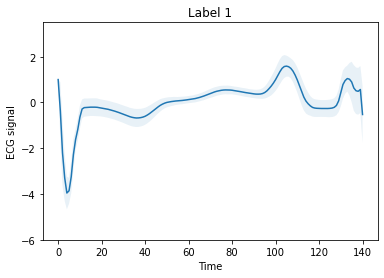

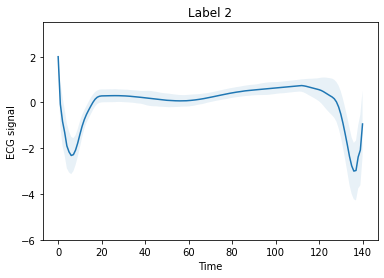

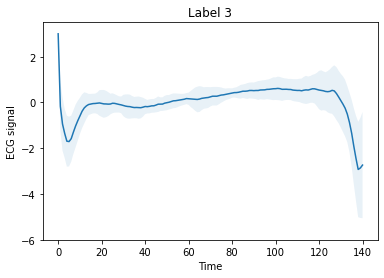

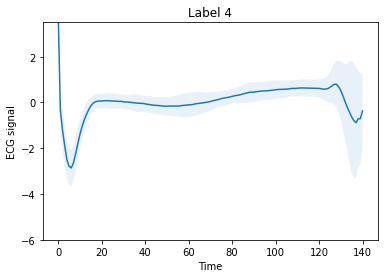

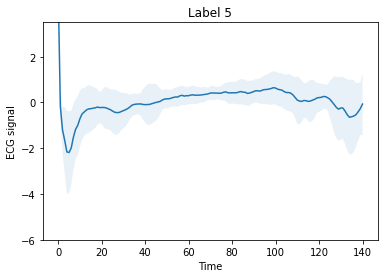

[None, None, None, None, None]

In [6]:
labels = data['label']
unique_labels = set(labels)

[plotSamplesOfOneLabel(data, x) for x in unique_labels]

In [7]:
def Normalize(np_array):
    
    minimum = np.amin(np_array)
    np_array += abs(minimum)
    
    maximum = np.amax(np_array)
    np_array = np_array / maximum
    
    return np_array

In [8]:
data_matrix = data.to_numpy()
np.random.shuffle(data_matrix)

labels = data_matrix[:,0]
ecg_data = data_matrix[:, 1:]

X = Normalize(ecg_data)

print("The shape of input data X is:\t\t\t", X.shape,
      "\nWith as minimum and maximum values in the data:\t", (np.amin(X), np.amax(X)),
      "\nThe length of label array:\t\t\t", len(labels)
     )

The shape of input data X is:			 (5000, 140) 
With as minimum and maximum values in the data:	 (0.0, 1.0) 
The length of label array:			 5000


In [9]:
NUM_OF_SAMPLES, SAMPLE_SIZE = X.shape
LATENT_DIM = 5
EPOCHS= 1500
BATCH_SIZE = 32
LSTM_LAYER = 128
NUM_DIMENSIONS = 1
LEARNING_RATE = 0.001

In [10]:
def Sampling(args):
    
    mu, log_sigma = args
    
    epsilon = K.random_normal(shape=(LATENT_DIM,), mean=0., stddev=1.)
    
    sample = mu + K.exp(log_sigma / 2) * epsilon
    
    return sample

In [11]:
X = X.reshape(NUM_OF_SAMPLES, SAMPLE_SIZE, NUM_DIMENSIONS)
X.shape

(5000, 140, 1)

In [12]:
enc_input = Input(shape=(SAMPLE_SIZE, NUM_DIMENSIONS))

enc_hidden = Bidirectional(LSTM(LSTM_LAYER))(enc_input)

mu = Dense(LATENT_DIM, activation='linear', name='mu')(enc_hidden)
log_sigma = Dense(LATENT_DIM, activation='linear', name='sigma')(enc_hidden)

z = Lambda(Sampling, output_shape=(LATENT_DIM, ), name='z')([mu, log_sigma])

encoder = Model(enc_input, [mu, log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          133120      input_1[0][0]                    
__________________________________________________________________________________________________
mu (Dense)                      (None, 5)            1285        bidirectional[0][0]              
__________________________________________________________________________________________________
sigma (Dense)                   (None, 5)            1285        bidirectional[0][0]              
____________________________________________________________________________________________

In [13]:
dec_input = Input(shape=(LATENT_DIM, NUM_DIMENSIONS))

dec_hidden = Bidirectional(LSTM(LSTM_LAYER))(dec_input)

dec_out = Dense(X.shape[1])(dec_hidden)

decoder = Model(dec_input, dec_out, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5, 1)]            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               133120    
_________________________________________________________________
dense (Dense)                (None, 140)               35980     
Total params: 169,100
Trainable params: 169,100
Non-trainable params: 0
_________________________________________________________________


In [14]:
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, dec_out, z_decoded):
        x = K.flatten(dec_out)
        z_decoded = K.flatten(z_decoded)
        
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + log_sigma - K.square(mu) - K.exp(log_sigma), axis=-1)
        
        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x, z_decoded = inputs
        
        loss = self.vae_loss(x, z_decoded)
        
        self.add_loss(loss, inputs=inputs)
        
        return x

In [15]:
z_decoded = decoder(z)

y = CustomLayer()([enc_input, z_decoded])

vae = Model(enc_input, y, name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 256)          133120      input_1[0][0]                    
__________________________________________________________________________________________________
mu (Dense)                      (None, 5)            1285        bidirectional[0][0]              
__________________________________________________________________________________________________
sigma (Dense)                   (None, 5)            1285        bidirectional[0][0]              
________________________________________________________________________________________________

In [16]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = LEARNING_RATE), loss=None)

history = vae.fit(
    X,
    None,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_split = 0.1,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=1000, mode="min")
    ],
).history

Train on 4500 samples, validate on 500 samples
Epoch 1/1500
4480/4500 [============================>.] - ETA: 0s - loss: 2.1719

C:\Users\Ruben\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4500/4500 [==============================] - 11s 2ms/sample - loss: 2.1693 - val_loss: 1.5923
Epoch 2/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 1.5879 - val_loss: 1.5864
Epoch 3/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 1.5846 - val_loss: 1.5842
Epoch 4/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 1.5840 - val_loss: 1.5835
Epoch 5/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 1.5840 - val_loss: 1.5831
Epoch 6/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 1.5836 - val_loss: 1.5827
Epoch 7/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 1.5836 - val_loss: 1.5827
Epoch 8/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 1.5835 - val_loss: 1.5829
Epoch 9/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 1.5836 - val_loss: 1.5831
Epoch 10/1500
4500/4500 [=========================

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6889 - val_loss: 0.6885
Epoch 78/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6887 - val_loss: 0.6885
Epoch 79/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6885 - val_loss: 0.6884
Epoch 80/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6885 - val_loss: 0.6882
Epoch 81/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6884 - val_loss: 0.6886
Epoch 82/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6884 - val_loss: 0.6881
Epoch 83/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6883 - val_loss: 0.6882
Epoch 84/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6882 - val_loss: 0.6880
Epoch 85/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6882 - val_loss: 0.6881
Epoch 86/1500
4500/4500 [=================

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6858 - val_loss: 0.6856
Epoch 153/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6858 - val_loss: 0.6859
Epoch 154/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6858 - val_loss: 0.6856
Epoch 155/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6858 - val_loss: 0.6856
Epoch 156/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6857 - val_loss: 0.6856
Epoch 157/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6857 - val_loss: 0.6854
Epoch 158/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6857 - val_loss: 0.6856
Epoch 159/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6856 - val_loss: 0.6855
Epoch 160/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6856 - val_loss: 0.6856
Epoch 161/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6854 - val_loss: 0.6853
Epoch 228/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6854 - val_loss: 0.6853
Epoch 229/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6853 - val_loss: 0.6852
Epoch 230/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6853 - val_loss: 0.6852
Epoch 231/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6853 - val_loss: 0.6852
Epoch 232/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6853 - val_loss: 0.6853
Epoch 233/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6853 - val_loss: 0.6852
Epoch 234/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6854 - val_loss: 0.6853
Epoch 235/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6852 - val_loss: 0.6851
Epoch 236/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6847
Epoch 303/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6849
Epoch 304/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6849 - val_loss: 0.6848
Epoch 305/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6848
Epoch 306/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6849 - val_loss: 0.6847
Epoch 307/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6848
Epoch 308/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6848
Epoch 309/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6848
Epoch 310/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6849 - val_loss: 0.6848
Epoch 311/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6848
Epoch 378/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6847
Epoch 379/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6848
Epoch 380/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6848
Epoch 381/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6846
Epoch 382/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6847
Epoch 383/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6848
Epoch 384/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6847
Epoch 385/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6849
Epoch 386/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 453/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 454/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 455/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 456/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6847
Epoch 457/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6848
Epoch 458/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 459/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6848
Epoch 460/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 461/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 528/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6848
Epoch 529/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 530/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 531/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 532/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6848
Epoch 533/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 534/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 535/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6848
Epoch 536/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6845
Epoch 603/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 604/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 605/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 606/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 607/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 608/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 609/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 610/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 611/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 678/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 679/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 680/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 681/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6848 - val_loss: 0.6846
Epoch 682/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 683/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6848
Epoch 684/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 685/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 686/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 753/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 754/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 755/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 756/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 757/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 758/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 759/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 760/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 761/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 828/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 829/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 830/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 831/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 832/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 833/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 834/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 835/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 836/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 903/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 904/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 905/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 906/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 907/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 908/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 909/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6847
Epoch 910/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 911/1500
4500/4500 [========

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 978/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 979/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 980/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 981/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 982/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 983/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6847 - val_loss: 0.6846
Epoch 984/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6845
Epoch 985/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6848
Epoch 986/1500
4500/4500 [========

Epoch 1052/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1053/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1054/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1055/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1056/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1057/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1058/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1059/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6848
Epoch 1060/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1061

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1127/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1128/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1129/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1130/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1131/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1132/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1133/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1134/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1135/1500
4500/4500 

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1201/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1202/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1203/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1204/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1205/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1206/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1207/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1208/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6845
Epoch 1209/1500
4500/4500 

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6845
Epoch 1275/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6845 - val_loss: 0.6846
Epoch 1276/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1277/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1278/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1279/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1280/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1281/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1282/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1283/1500
4500/4500 

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6845 - val_loss: 0.6847
Epoch 1349/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1350/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1351/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1352/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1353/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1354/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1355/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1356/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1357/1500
4500/4500 

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1423/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6845 - val_loss: 0.6846
Epoch 1424/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1425/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1426/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1427/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6848
Epoch 1428/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1429/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1430/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1431/1500
4500/4500 

4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846
Epoch 1497/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1498/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1499/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6847
Epoch 1500/1500
4500/4500 [==============================] - 10s 2ms/sample - loss: 0.6846 - val_loss: 0.6846


In [17]:
mu, _, _ = encoder.predict(X)

print("Shape should be: (", X.shape[0], ",", LATENT_DIM, "):" ,mu.shape)

Shape should be: ( 5000 , 5 ): (5000, 5)


In [18]:
pca = PCA(n_components = 2)
pca_outcome = pca.fit_transform(mu)

print("Shape should be: (", X.shape[0], ", 2 ):", pca_outcome.shape)

Shape should be: ( 5000 , 2 ): (5000, 2)


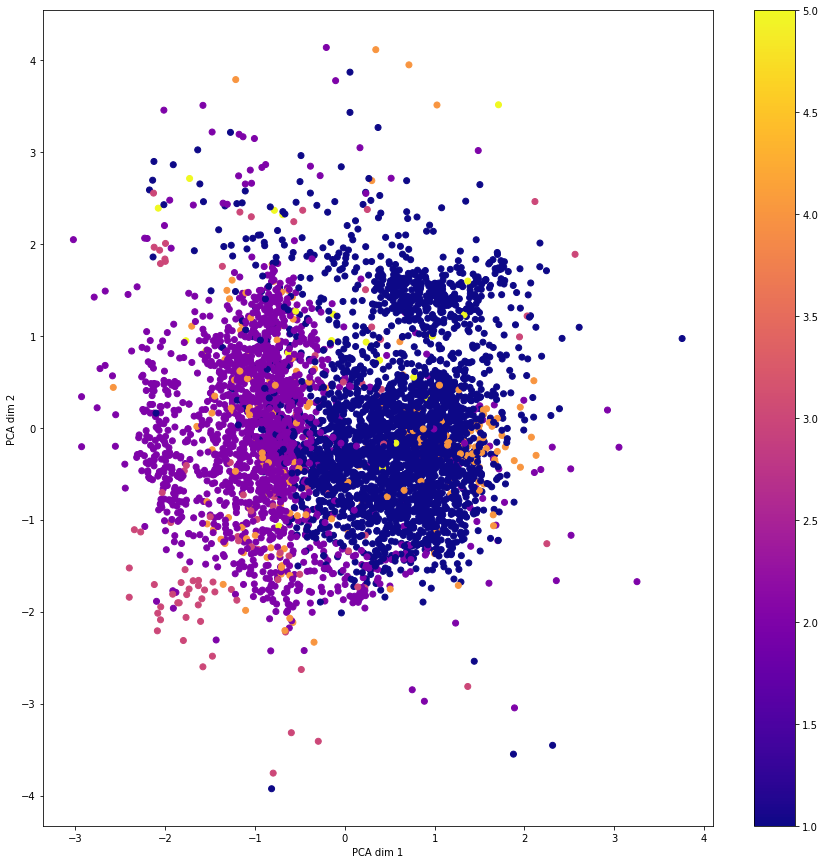

In [19]:
plt.figure(figsize=(15, 15))

plt.scatter(pca_outcome[:, 0], pca_outcome[:, 1], c = labels, cmap='plasma')
plt.xlabel('PCA dim 1')
plt.ylabel('PCA dim 2')

plt.colorbar()
plt.show()

In [20]:
tsne_outcome = TSNE(n_components=2, perplexity=50.0, n_iter=2000).fit_transform(mu)

print("Shape should be: (", X.shape[0], ", 2 ):", tsne_outcome.shape)

Shape should be: ( 5000 , 2 ): (5000, 2)


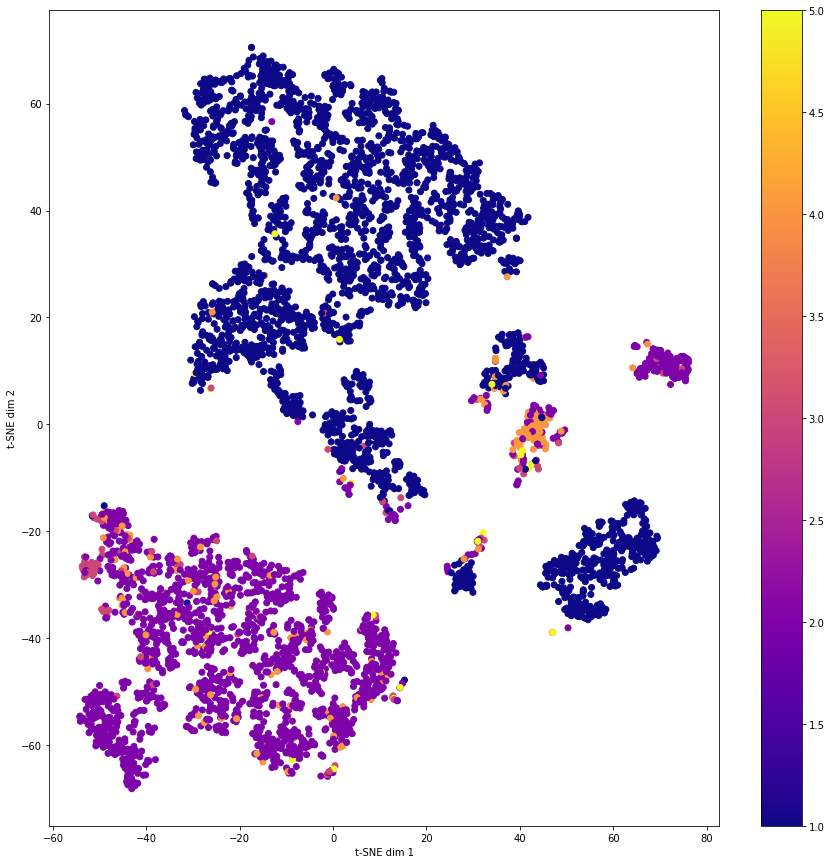

In [21]:
plt.figure(figsize=(15, 15))

plt.scatter(tsne_outcome[:, 0], tsne_outcome[:, 1], c=labels, cmap='plasma')
plt.xlabel('t-SNE dim 1')
plt.ylabel('t-SNE dim 2')

plt.colorbar()
plt.show()